# Pricing Behavior and Relative Acceptance in the Used Car Market

This report studies pricing behavior using a market consensus benchmark derived from a machine learning model.




# Toyota Used Car Market Mispricing Analysis

## 1. Business Problem

Is the used car market systematically mispricing certain Toyota models?

This project aims to:

- Estimate a fair benchmark price for each vehicle
- Identify undervalued acquisition opportunities
- Develop a data-driven purchasing strategy

Core Question:
Can we detect systematic market mispricing and convert it into profit?


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import rcParams
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import os
os.makedirs("images", exist_ok=True)

plt.rcParams['figure.figsize'] = (10, 6)  #  Use a smaller size for better readability
plt.rcParams['figure.dpi'] = 100  # # Reduce resolution for faster rendering
plt.rcParams['font.size'] = 10
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Dataset Overview

The dataset contains 6,738 Toyota used car listings, including:

- Model
- Year
- Mileage
- Fuel Type
- Transmission
- Engine Size
- Tax
- MPG
- Listing Price

The goal is to understand how these features determine a fair market price.


In [93]:
# Load raw listing data to reconstruct real-world dealer pricing environment
data = pd.read_csv(r"E:\项目集\丰田二手车市场洞察\toyota.csv")

## 3. Data Cleaning

To improve model robustness:

- Outliers are detected using the IQR method
- Extreme values are replaced with the median
- Missing values are removed if necessary

This ensures stability while preserving sample size.


In [94]:
# Define function: Detect outliers using IQR and replace with median
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median = df[column].median()
    # Identify abnormal values (outliers) in the dataset
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    num_outliers = outliers.sum()
    df.loc[outliers, column] = median
    print(f"Replaced {num_outliers} outliers in {column} with median {median}")
    return df

# First process obviously invalid values: for records where engineSize <= 0, replace them with the median value (or remove the records if required)
median_engine = data['engineSize'].median()
data.loc[data['engineSize'] <= 0, 'engineSize'] = median_engine
print(f"Replaced invalid engineSize (<=0) with median {median_engine}")

# Apply to key numeric columns: year, mileage, price, tax, mpg, engineSize
columns_to_process = ['year', 'mileage', 'price', 'tax', 'mpg', 'engineSize']
for col in columns_to_process:
    data = replace_outliers_with_median(data, col)



Replaced invalid engineSize (<=0) with median 1.5
Replaced 212 outliers in year with median 2017.0
Replaced 269 outliers in mileage with median 18513.0
Replaced 258 outliers in price with median 10795.0
Replaced 3 outliers in tax with median 135.0
Replaced 208 outliers in mpg with median 62.8
Replaced 2 outliers in engineSize with median 1.5


In [95]:
data1 = data[['price','year','mileage','tax','mpg','engineSize']]

## 4.Exploratory Data Analysis

We examine:

- Correlation between numerical variables
- Relationship between price and year
- Relationship between price and mileage
- Price distribution across models


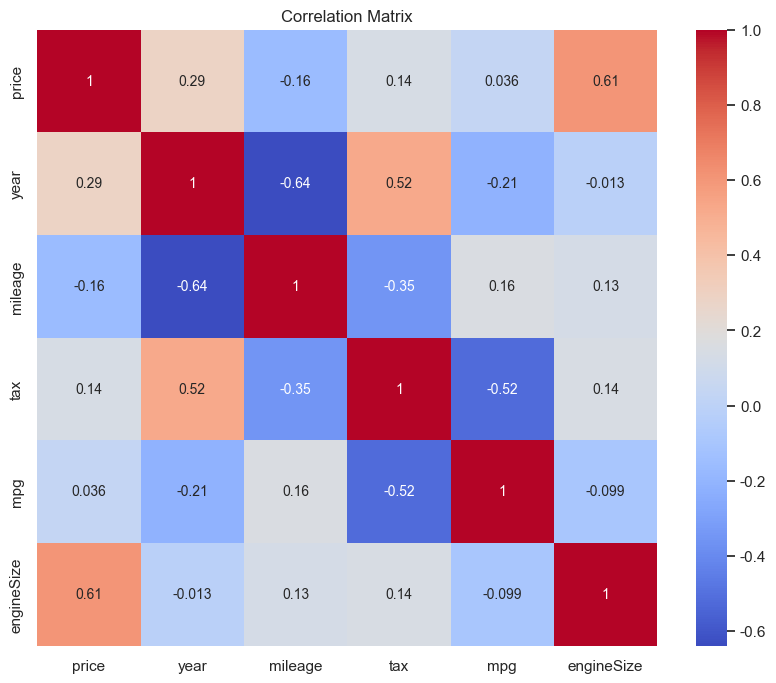

In [96]:
plt.figure(figsize=(10,8))
sns.heatmap(data1.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig("images/Correlation Matrix.png", dpi=150, bbox_inches="tight")
plt.show()



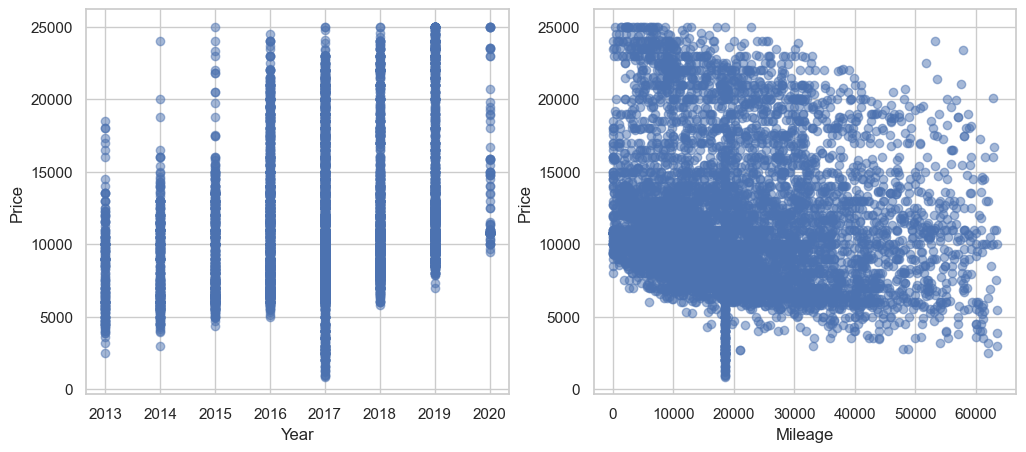

In [97]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(data['year'], data['price'], alpha=0.5)
plt.xlabel('Year')
plt.ylabel('Price')

plt.subplot(1, 2, 2)
plt.scatter(data['mileage'], data['price'], alpha=0.5)
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.savefig("images/Year vs Price and Mileage vs Price.png", dpi=150, bbox_inches="tight")
plt.show()


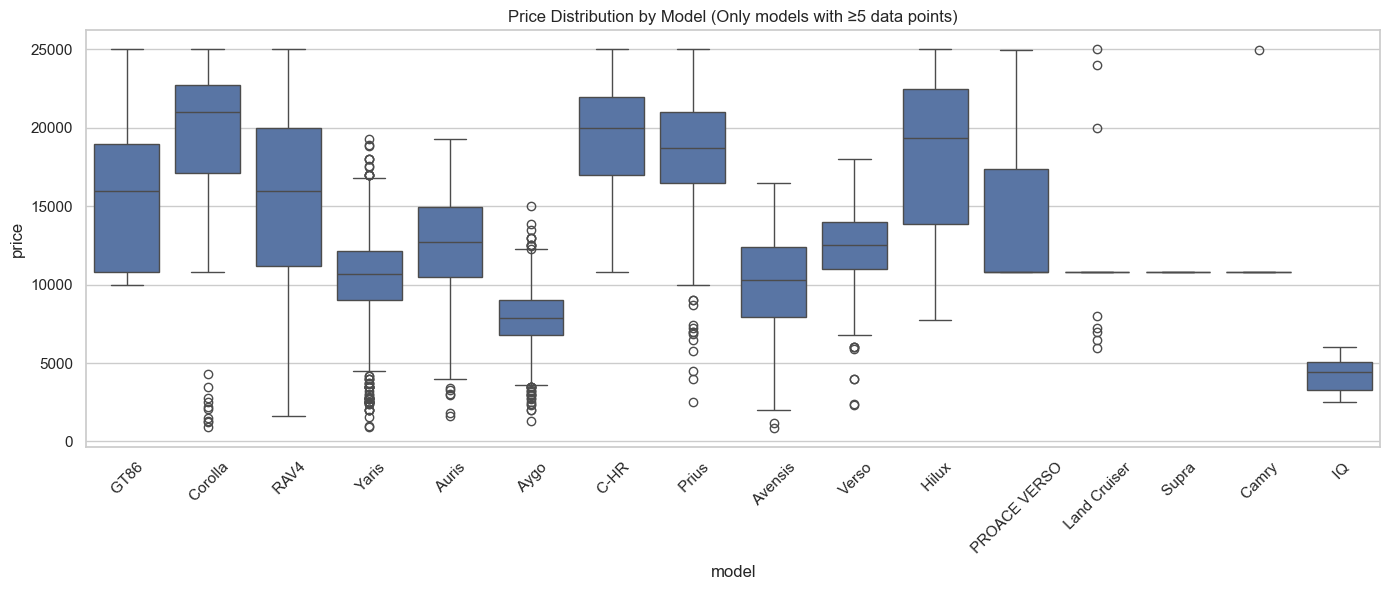

In [98]:
# Filter out car models with insufficient data volume.
model_counts = data['model'].value_counts()
valid_models = model_counts[model_counts >= 5].index  # Retain only vehicle models that have a minimum of 5 data points.
filtered_data = data[data['model'].isin(valid_models)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=filtered_data, x='model', y='price')
plt.xticks(rotation=45)
plt.title('Price Distribution by Model (Only models with ≥5 data points)')
plt.tight_layout()
plt.savefig("images/Price Distribution by Model.png", dpi=150, bbox_inches="tight")
plt.show()


In [99]:
data_price = data.copy()
numerical_features = [
    'year', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize'
]

categorical_features = [
    'fuelType', 
    'transmission', 
    'model'
]

X = data_price[numerical_features + categorical_features]
y = data_price['price']
# Encode categorical variables using One-Hot encoding.
X = pd.get_dummies(
    X,
    columns=categorical_features,
    drop_first=True
)
X.shape
X.columns[:10]
X.head()

,year,mileage,tax,mpg,engineSize,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,transmission_Manual,transmission_Other,...,model_ IQ,model_ Land Cruiser,model_ PROACE VERSO,model_ Prius,model_ RAV4,model_ Supra,model_ Urban Cruiser,model_ Verso,model_ Verso-S,model_ Yaris
0,2016,24089,265,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2017,18615,145,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,2015,27469,265,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,2017,14736,150,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,2017,36284,145,36.2,2.0,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


## 5. Fair Price Model Construction

Vehicle age is derived from production year.

Categorical variables are encoded using one-hot encoding.

A Random Forest regression model is trained to estimate fair vehicle prices.

Model performance is evaluated using R² score.



In [100]:
# Calculate vehicle age from production year.
data_price['age'] = 2020 - data_price['year']

numerical_features = [
    'age', 
    'mileage', 
    'tax', 
    'mpg', 
    'engineSize'
]

categorical_features = [
    'fuelType', 
    'transmission', 
    'model'
]

X = data_price[numerical_features + categorical_features]
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data_price['price']

# Split the training set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest model for the estimation of fair market value.
rf_model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict prices using the model.
data_price['predicted_price'] = rf_model.predict(X)

print("Train R²:", rf_model.score(X_train, y_train))
print("Test  R²:", rf_model.score(X_test, y_test))

Train R²: 0.9810815164791005
Test  R²: 0.8633050152087258


The performance gap between training and testing set suggests mild overfitting,
which is acceptable given the model's role as a relative valuation benchmark
rather than a precise forecasting tool.


## Model Performance

The Random Forest model achieves strong explanatory power.

A high R² indicates that vehicle features explain most price variation,
allowing the predicted value to serve as a reliable fair benchmark.


## 6. Mispricing Index Definition

We compute the mispricing index for each vehicle:

We refer to this ratio as the Market Acceptance Index (MAI), which measures relative positioning rather than pricing correctness.

Mispricing Index = Actual Price / Predicted Price

This allows us to detect systematic overpricing and underpricing.


In [101]:

data_price['relative_deviation_index'] = data_price['price'] / data_price['predicted_price']

## Economic Meaning of Mispricing Index

Mispricing_index = Market Price / Fair Price

Interpretation:

Mispricing_index = 1.0  → fairly priced 

Mispricing_index < 1.0 → undervalued (potential acquisition opportunity)

Mispricing_index > 1.0 → overvalued (avoid purchasing)

This metric transforms a prediction task into a trading decision indicator.

In [102]:
# Group by car model and calculate the average relative_deviation index.
residual_by_model = data_price.groupby('model').agg({
    'relative_deviation_index': 'mean',
    'price': 'mean',
    'age': 'mean',
    'mileage': 'mean'
})

# Filter models with sufficient sample size (>30 vehicles).
residual_by_model = residual_by_model[residual_by_model['relative_deviation_index'].notna()]
residual_by_model = residual_by_model.sort_values('relative_deviation_index', ascending=False)

# Add sample size field.
residual_by_model['sample_size'] = data_price.groupby('model').size()

# Keep only car models with sample size > 30.
residual_by_model = residual_by_model[residual_by_model['sample_size'] >= 30]

# Display the ranking of the relative_deviation index.
residual_by_model[['relative_deviation_index', 'sample_size']].head(10)

,relative_deviation_index,sample_size
model,,
Land Cruiser,1.023119,51
Prius,1.001987,232
Verso,1.000051,114
Aygo,0.998574,1961
Yaris,0.997282,2122
RAV4,0.996693,473
Auris,0.995463,712
Corolla,0.993737,267
C-HR,0.990049,479


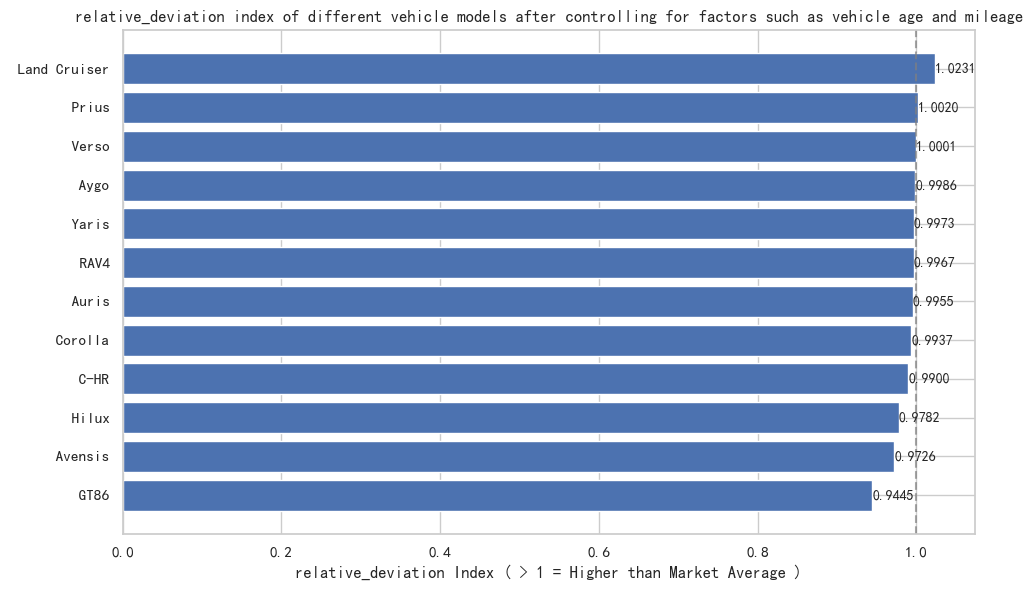

In [103]:
plt.figure(figsize=(10,6))
bars = plt.barh(
    residual_by_model.index,
    residual_by_model['relative_deviation_index']
)

# Add data labels on each bar.
for bar in bars:
    width = bar.get_width()  # Get the width of the bars, which corresponds to the relative_deviation_index value.
    plt.text(width, bar.get_y() + bar.get_height() / 2, 
             f'{width:.4f}',  # Format to 4 decimal places.
             va='center', ha='left', fontsize=10)

# Add a dividing line.
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.axvline(1.0, linestyle='--', color='gray', alpha=0.7)  # Dividing line: 1.0 represents the average market relative_deviation index.
plt.xlabel('relative_deviation Index ( > 1 = Higher than Market Average )')
plt.title('relative_deviation index of different vehicle models after controlling for factors such as vehicle age and mileage')
plt.gca().invert_yaxis()  # Ensure the most important models are displayed at the top.
plt.tight_layout()
plt.savefig("images/relative_deviation index of different vehicle models.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Market Mispricing Distribution

We visualize the distribution of the mispricing index.

Thresholds at 0.85 and 1.15 classify vehicles into:

- Undervalued
- Fair
- Overvalued


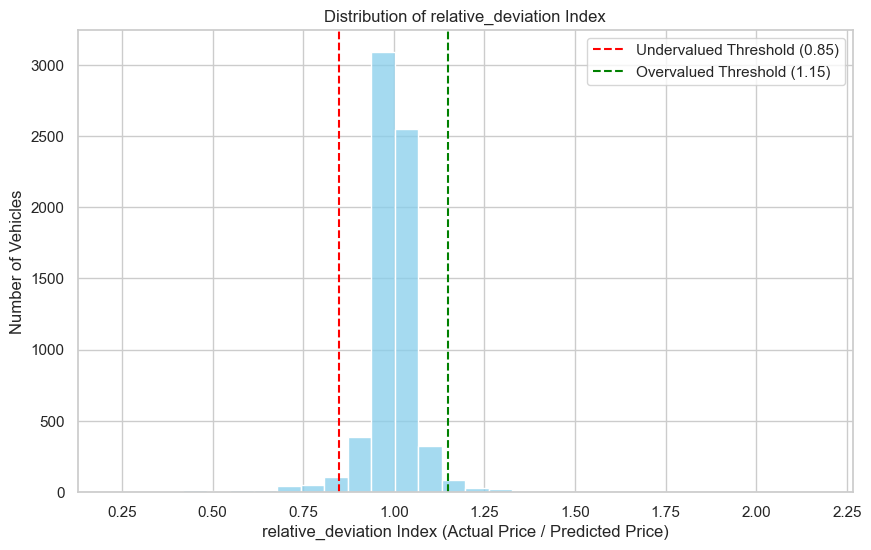

In [104]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.histplot(data_price['relative_deviation_index'], bins=30, kde=False, color='skyblue')

# Add dividing lines at 0.85 and 1.15.
plt.axvline(x=0.85, color='red', linestyle='--', label='Undervalued Threshold (0.85)')
plt.axvline(x=1.15, color='green', linestyle='--', label='Overvalued Threshold (1.15)')

plt.title('Distribution of relative_deviation Index')
plt.xlabel('relative_deviation Index (Actual Price / Predicted Price)')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.savefig("images/Distribution of relative_deviation Index.png", dpi=150, bbox_inches="tight")
plt.show()

## Model Reliability

The regression model is not used for precise price prediction, but for estimating a fair relative valuation baseline.

Therefore, the absolute prediction error is less important than the relative ranking ability.

If the model can correctly differentiate cheaper vs more expensive vehicles,
the mispricing index becomes economically meaningful.

This converts a machine learning model into a market valuation benchmark.


## Market Classification

To operationalize strategy, we define thresholds:

- Mispricing_index < 0.85 → Undervalued (Buy Signal)
- Mispricing_index in [0.85,1.15] → Fair
- Mispricing_index > 1.15 → Overvalued


In [105]:
# Count the number of undervalued, overvalued, and fairly valued vehicles.
total = len(data_price)
undervalued = len(data_price[data_price['relative_deviation_index'] < 0.85])
overvalued = len(data_price[data_price['relative_deviation_index'] > 1.15])
fair = total - undervalued - overvalued

print(f"Total vehicles: {total}")
print(f"Undervalued (<0.85): {undervalued} ({undervalued/total:.2%})")
print(f"Overvalued (>1.15): {overvalued} ({overvalued/total:.2%})")
print(f"Fairly priced (0.85~1.15): {fair} ({fair/total:.2%})")

Total vehicles: 6738
Undervalued (<0.85): 190 (2.82%)
Overvalued (>1.15): 117 (1.74%)
Fairly priced (0.85~1.15): 6431 (95.44%)


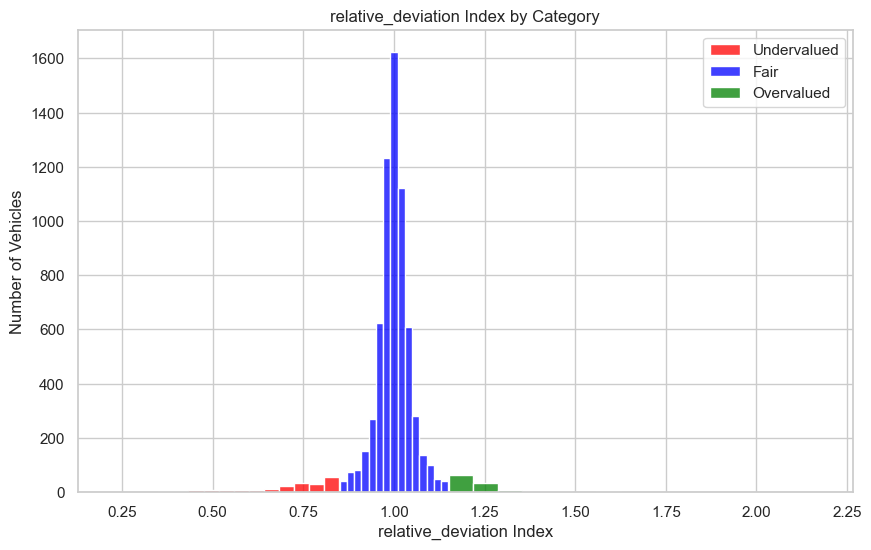

In [106]:
plt.figure(figsize=(10,6))
sns.histplot(data_price[data_price['relative_deviation_index'] < 0.85]['relative_deviation_index'], bins=15, color='red', label='Undervalued')
sns.histplot(data_price[(data_price['relative_deviation_index'] >= 0.85) & (data_price['relative_deviation_index'] <= 1.15)]['relative_deviation_index'], bins=15, color='blue', label='Fair')
sns.histplot(data_price[data_price['relative_deviation_index'] > 1.15]['relative_deviation_index'], bins=15, color='green', label='Overvalued')

plt.title('relative_deviation Index by Category')
plt.xlabel('relative_deviation Index')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.savefig("images/relative_deviation Index by Category.png", dpi=150, bbox_inches="tight")
plt.show()

##  Interpretation

Vehicles priced significantly below the estimated fair value represent acquisition opportunities.

Dealers can purchase undervalued cars and resell them near fair price,
capturing the price spread as profit.

This turns the analysis into a practical pricing and procurement strategy.


In [107]:
# Group by car model and calculate the average relative_deviation index.
model_relative_deviation = data_price.groupby('model')['relative_deviation_index'].mean().sort_values(ascending=False)

# View the top 10 most overvalued models and the top 10 most undervalued models.
print("Top 10 Overvalued Models:")
print(model_relative_deviation.head(10))
print("\nTop 10 Undervalued Models:")
print(model_relative_deviation.tail(10))

Top 10 Overvalued Models:
model
Land Cruiser    1.023119
Verso-S         1.008485
Prius           1.001987
Verso           1.000051
Aygo            0.998574
Yaris           0.997282
RAV4            0.996693
Auris           0.995463
Corolla         0.993737
Supra           0.990866
Name: relative_deviation_index, dtype: float64

Top 10 Undervalued Models:
model
Corolla          0.993737
Supra            0.990866
C-HR             0.990049
Hilux            0.978194
PROACE VERSO     0.976772
Avensis          0.972606
Camry            0.957978
Urban Cruiser    0.947564
GT86             0.944475
IQ               0.931224
Name: relative_deviation_index, dtype: float64


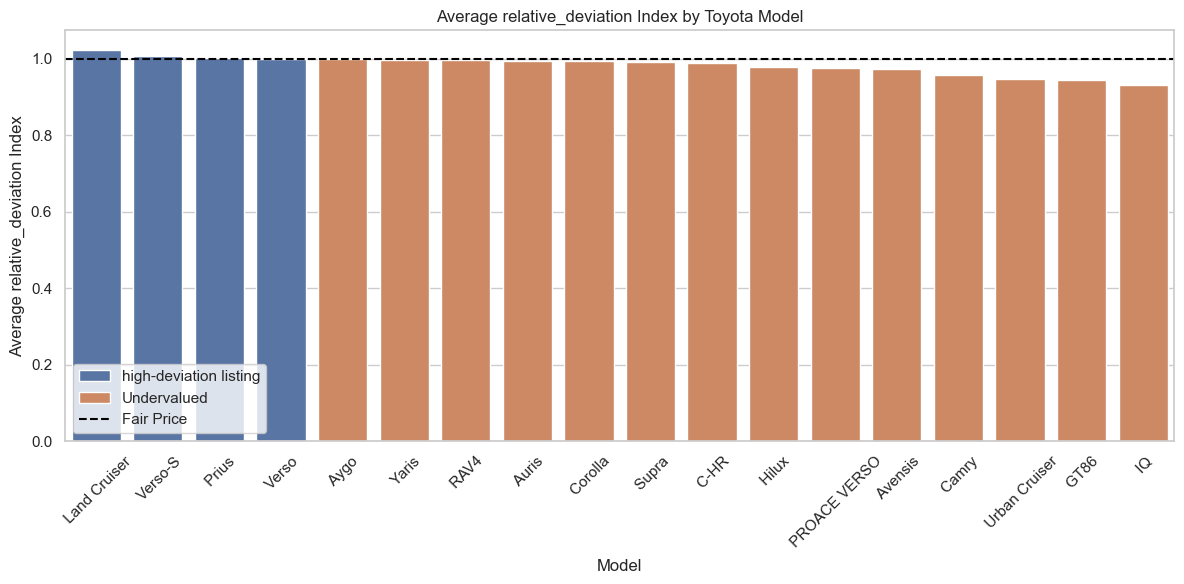

In [108]:
plot_df = model_relative_deviation.reset_index()
plot_df.columns = ['Model', 'relative_deviation']

plot_df['valuation'] = plot_df['relative_deviation'].apply(
    lambda x: 'Undervalued' if x < 1 else 'high-deviation listing'
)

plt.figure(figsize=(12,6))

sns.barplot(
    data=plot_df,
    x='Model',
    y='relative_deviation',
    hue='valuation',
    dodge=False
)

plt.axhline(1, color='black', linestyle='--', label='Fair Price')
plt.xticks(rotation=45)
plt.ylabel('Average relative_deviation Index')
plt.title('Average relative_deviation Index by Toyota Model')
plt.legend()
plt.tight_layout()
plt.savefig("images/Average relative_deviation Index by Toyota Model.png", dpi=150, bbox_inches="tight")
plt.show()



In [109]:
# Create a pivot table: car model × vehicle age.
heatmap_data = data_price.pivot_table(
    index='model', 
    columns='age', 
    values='relative_deviation_index', 
    aggfunc='mean'
)

# Check the first few rows.
heatmap_data.head()

age,0,1,2,3,4,5,6,7
model,,,,,,,,
Auris,NaN,0.970435,0.993489,0.991473,0.999858,0.999881,0.993635,0.997953
Avensis,NaN,NaN,1.017851,0.938593,0.983916,1.030038,0.991614,0.992585
Aygo,1.010076,0.997296,1.001284,0.997080,0.999554,0.998000,0.998150,0.999867
C-HR,0.925984,0.961376,1.004906,0.998095,0.992119,NaN,NaN,NaN
Camry,0.958009,0.957975,NaN,NaN,NaN,NaN,NaN,NaN


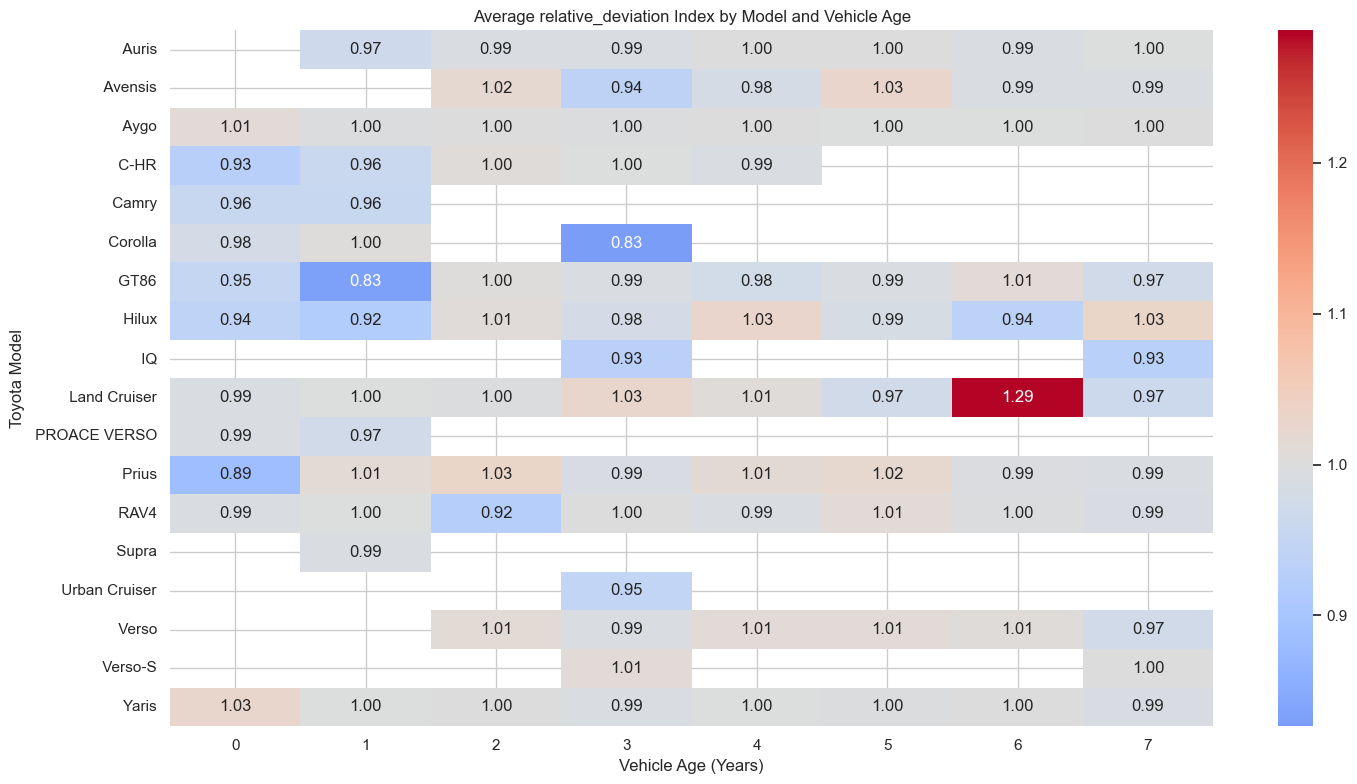

In [110]:
plt.figure(figsize=(15,8))
sns.heatmap(
    heatmap_data, 
    annot=True,           # Display numerical values
    fmt=".2f",            # Round to two decimal places.
    cmap="coolwarm",      # Blue-white-red: undervalued - fairly valued - overvalued
    center=1               # Take 1 as the midline, with the color centered.
)

plt.title('Average relative_deviation Index by Model and Vehicle Age')
plt.xlabel('Vehicle Age (Years)')
plt.ylabel('Toyota Model')
plt.tight_layout()
plt.savefig("images/Average relative_deviation Index by Model and Vehicle Age.png", dpi=150, bbox_inches="tight")
plt.show()

In [111]:
# Add a new column 'buy_signal': True indicates a recommended acquisition.
data_price['buy_signal'] = data_price['relative_deviation_index'] < 0.85

# Calculate the number of vehicles recommended for acquisition.
buy_count = data_price['buy_signal'].sum()
total_count = len(data_price)
print(f"Total vehicles: {total_count}")
print(f"Suggested to buy: {buy_count} ({buy_count/total_count:.2%})")

Total vehicles: 6738
Suggested to buy: 190 (2.82%)


## 8. Strategy Backtesting


This simulates a data-driven acquisition strategy.


In [112]:
# Only vehicles recommended for acquisition are included in the potential interpretation calculation.
data_price['potential_interpretation'] = data_price['predicted_price'] - data_price['price']

# Average potential interpretation under the strategy
avg_interpretation = data_price.loc[data_price['buy_signal'], 'potential_interpretation'].mean()
total_interpretation = data_price.loc[data_price['buy_signal'], 'potential_interpretation'].sum()

print(f"Average potential interpretation per vehicle: £{avg_interpretation:.2f}")
print(f"Total potential interpretation if all recommended vehicles are bought: £{total_interpretation:.2f}")

Average potential interpretation per vehicle: £3216.38
Total potential interpretation if all recommended vehicles are bought: £611111.70


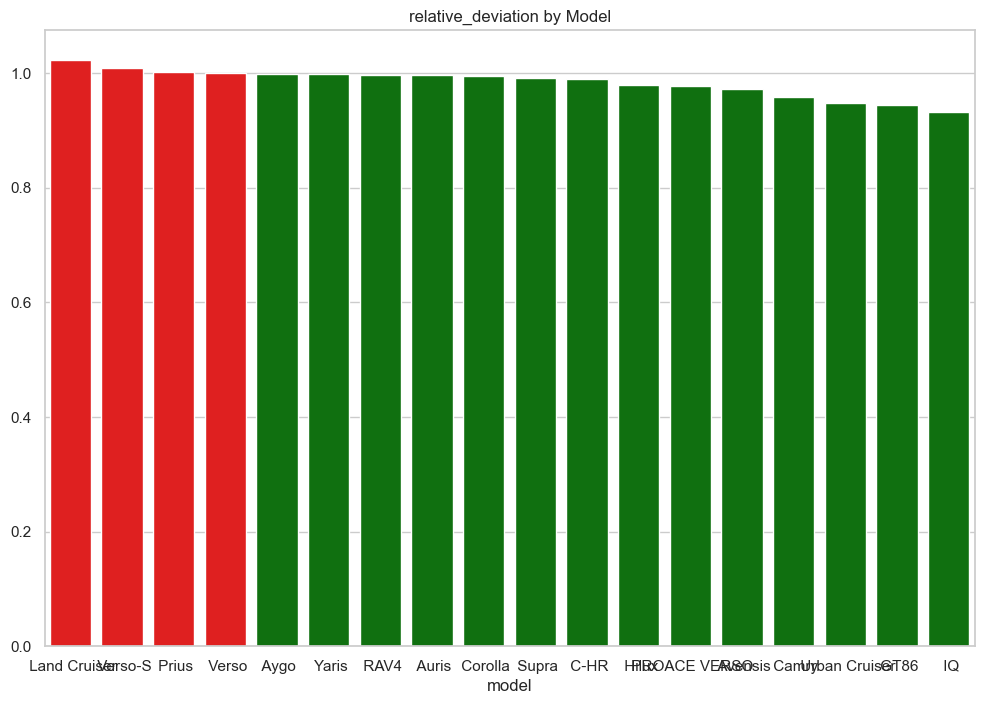

In [113]:
colors = ['green' if x < 1 else 'red' for x in model_relative_deviation.values]

sns.barplot(
    x=model_relative_deviation.index,
    y=model_relative_deviation.values,
    hue=model_relative_deviation.index,
    palette=colors,
    legend=False
)
plt.title('relative_deviation by Model')
plt.savefig("images/relative_deviation by Model.png", dpi=150, bbox_inches="tight")

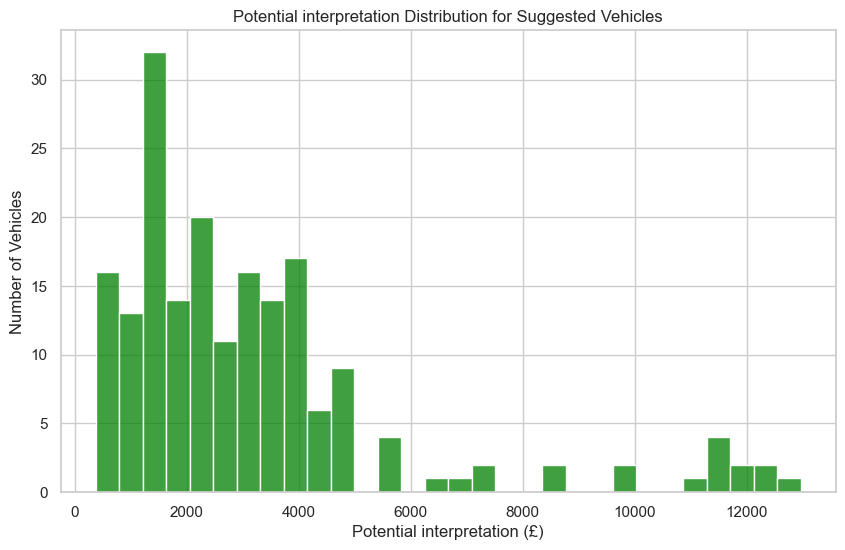

In [114]:
plt.figure(figsize=(10,6))
sns.histplot(data_price.loc[data_price['buy_signal'], 'potential_interpretation'], bins=30, color='green')
plt.title('Potential interpretation Distribution for Suggested Vehicles')
plt.xlabel('Potential interpretation (£)')
plt.ylabel('Number of Vehicles')
plt.savefig("images/Potential interpretation Distribution for Suggested Vehicles.png", dpi=150, bbox_inches="tight")
plt.show()

In [115]:
interpretation_by_model = data_price[data_price['buy_signal']].groupby('model')['potential_interpretation'].mean().sort_values(ascending=False)
print(interpretation_by_model.head(10))

model
GT86            7972.731616
PROACE VERSO    6596.241667
Hilux           5089.411681
C-HR            4754.741616
Corolla         3677.817655
Camry           3221.241667
Prius           2608.241985
RAV4            2523.705704
Auris           2307.284020
Avensis         1791.522917
Name: potential_interpretation, dtype: float64


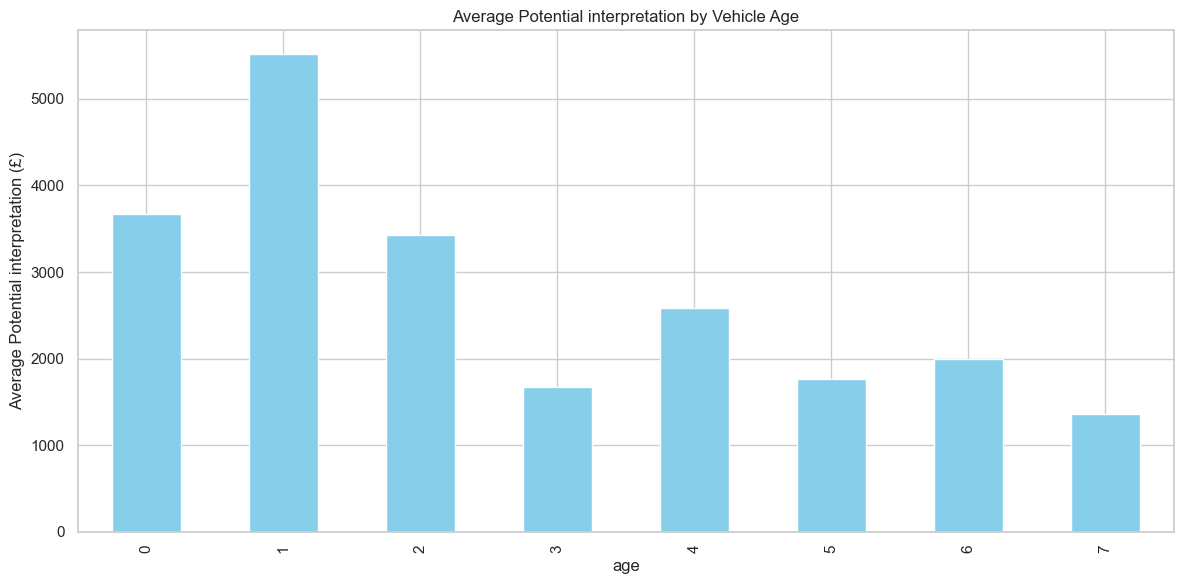

In [116]:
interpretation_by_age = data_price[data_price['buy_signal']].groupby('age')['potential_interpretation'].mean()
interpretation_by_age.plot(kind='bar', figsize=(12,6), color='skyblue')
plt.ylabel('Average Potential interpretation (£)')
plt.title('Average Potential interpretation by Vehicle Age')
plt.tight_layout()
plt.savefig("images/Average Potential interpretation by Vehicle Age.png", dpi=150, bbox_inches="tight")
plt.show()

### Limitations

This backtest represents a theoretical upper bound of profitability.

The following real-world factors are not included:

- Transaction costs (inspection, transportation, dealer margin)
- Market liquidity constraints
- Time required to resell vehicles
- Model stability over time

Therefore, actual realized profit may be lower than estimated.

## Pricing Strategy Framework

Based on the mispricing index:

Mispricing_index < 0.85 → strong buy candidate

Mispricing_index in [0.85,1.15] → normal market transaction 
 
Mispricing_index > 1.15 → avoid purchase

This provides an objective acquisition rule replacing subjective dealer judgment.


## 9. Key Findings & Conclusion

1. The used car market is largely efficient.
2. However, measurable pricing inefficiencies exist.
3. Approximately 2–3% of vehicles are significantly undervalued.
4. A data-driven acquisition strategy can generate substantial profit per vehicle.

Conclusion:

Machine learning can move pricing decisions from intuition-based
to evidence-based strategy.

This framework can be extended to other automotive markets.
